<font size="3">Importing Required Libraries:

In this section, we import the necessary libraries for data handling, visualization, preprocessing, and building the deep learning model.</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , Dropout , Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

<font size=3>Loading and Exploring the Dataset

We load the dataset and check its structure, including image dimensions and labels. This helps us understand what kind of data we are working with.</font>

In [ ]:
train_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0 ,
    shear_range = 0.1 , 
    zoom_range = 0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)
test_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0 ,
)

In [3]:
train_data = train_generator.flow_from_directory('chest_xray/chest_xray/train' ,
 class_mode='binary' ,
  color_mode='grayscale' , 
  batch_size=40 , 
  target_size=(500 , 500)
)
test_data = train_generator.flow_from_directory('chest_xray/chest_xray/test' ,
 class_mode='binary' ,
  color_mode='grayscale' ,
   batch_size=40 , 
   target_size=(500 , 500)
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
np.shape(train_data.classes)

(5216,)

In [5]:
np.shape(test_data.classes)

(624,)

<font size=3>make a model</font>

In [ ]:
model = Sequential([
    Conv2D(32 , 3 , activation='relu' , input_shape=(500,500 ,1)),
    MaxPool2D(pool_size=2 , strides=2) , 
    Dropout(0.1),
    Conv2D(64 , 3 , activation='relu'),
    MaxPool2D(2 , 2),
    Dropout(0.1),
    Conv2D(128 , 3 , activation='relu'),
    MaxPool2D(pool_size=2 , strides=2),
    Dropout(0.2),
    Conv2D(256 , 3 , activation='relu'),
    MaxPool2D(2 , 2),
    Dropout(0.40),
    Flatten(),
    Dense(64 , activation='relu'),
    Dense(128 , activation='relu'),
    Dense(1 , activation='sigmoid')
])

<font size=3>compile model</font>

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001) , loss='binary_crossentropy', metrics=['accuracy'])

<font size=3>imbalance data</font>

In [8]:
np.unique(train_data.classes , return_counts=True)

(array([0, 1]), array([1341, 3875], dtype=int64))

<font size=3>balance of classes</font>

In [9]:
class_weights = compute_class_weight(class_weight='balanced' , classes=np.unique(train_data.classes) , y=train_data.classes)
class_weights

array([1.9448173 , 0.67303226])

In [10]:
weights = dict(zip(np.unique(train_data.classes) , class_weights))
weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

<font size = 3>### Callbacks in Model Training

In deep learning, callbacks are a way to customize the training process by monitoring and taking actions based on the performance during training. Below are the callbacks used in this model:

#### 1. Early Stopping
This callback monitors the validation loss and stops training if the loss does not improve after a specified number of epochs (patience). It helps to avoid overfitting by preventing unnecessary training when the model has reached its best performance.

`python
early_stop = EarlyStopping(monitor='val_loss', patience=50, mode='min')

monitor='val_loss': Monitors the validation loss during training.

patience=4: Stops training if no improvement in validation loss after 50 epochs.

mode='min': The training will stop when the monitored value (validation loss) has stopped decreasing.


2. Reduce Learning Rate on Plateau

This callback reduces the learning rate by a specified factor if the validation loss plateaus for a certain number of epochs. It helps to fine-tune the model's performance after initial improvements.

rlop = ReduceLROnPlateau(monitor='val_loss', patience=50, factor=0.2, min_lr=0.001)

monitor='val_loss': Monitors the validation loss to detect when to reduce the learning rate.

patience=3: Number of epochs with no improvement before reducing the learning rate.

factor=0.5: The factor by which the learning rate will be reduced.

min_lr=0.001: The lower bound for the learning rate.


3. Model Checkpoint

This callback saves the best model based on the lowest validation loss during training, ensuring that the best performing model is retained.

check_point = ModelCheckpoint('best_xray_model.h5', monitor='val_loss', mode='min', save_best_only=True)

monitor='val_loss': Saves the model with the lowest validation loss.

mode='min': Monitors when the validation loss is minimized.

save_best_only=True: Saves only the best model (with the lowest validation loss).


Final Integration in Training

These callbacks are then passed into the model.fit() method, ensuring they are used during training:

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[early_stop, rlop, check_point])

Using these callbacks, the training process is optimized, ensuring the model's best performance while avoiding overfitting and unnecessary training </font>

In [11]:
early_stop = EarlyStopping(monitor='val_loss' , patience=4 , mode='min' )
rlop = ReduceLROnPlateau(monitor='val_loss' , patience=3 , factor=0.5 , min_lr=0.001)
check_point =  ModelCheckpoint('best_xray_model.h5' , monitor='val_loss' , model='min' , save_best_only=True)

<font size = "3">fiting the model</font>

In [12]:
history = model.fit_generator(train_data , steps_per_epoch=len(train_data) , validation_data=test_data , validation_steps=len(test_data), callbacks=[early_stop , check_point , rlop] , class_weight=weights , epochs=20)

C:\Users\T A T\AppData\Local\Temp\ipykernel_8364\2680768225.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data , steps_per_epoch=len(train_data) , validation_data=test_data , validation_steps=len(test_data), callbacks=[early_stop , check_point , rlop] , class_weight=weights , epochs=20)


Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.7188

c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 617s 5s/step - loss: 0.5249 - accuracy: 0.7188 - val_loss: 0.5352 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 618s 5s/step - loss: 0.3797 - accuracy: 0.8140 - val_loss: 0.4420 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 614s 5s/step - loss: 0.3336 - accuracy: 0.8503 - val_loss: 0.4291 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 611s 5s/step - loss: 0.2974 - accuracy: 0.8708 - val_loss: 0.4014 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 610s 5s/step - loss: 0.2876 - accuracy: 0.8769 - val_loss: 0.3763 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 6/20
131/131 [==============================] - 607s 5s/step - loss: 0.2569 - accuracy: 0.8865 - val_loss: 0.5140 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 7/20
131/131 [==============================] - 611s 5s/step - loss: 

<font size = "3">train loss and validation loss</font>


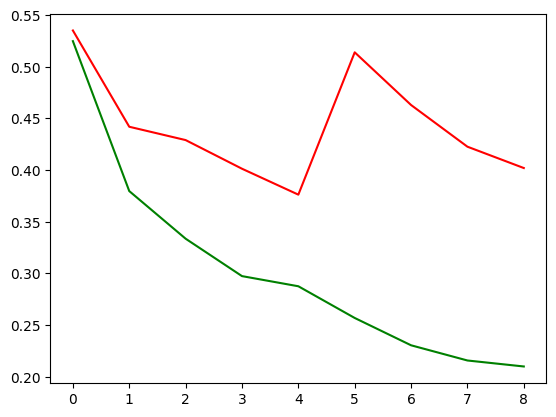

In [13]:
plt.plot(history.history['loss'] , color='green')
plt.plot(history.history['val_loss'] , color='red')

<font size = "3">train accuracy and validation accuracy</font>


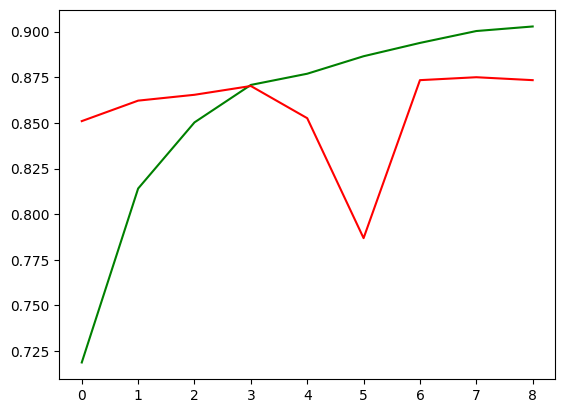

In [14]:
plt.plot(history.history['accuracy'] , color='green')
plt.plot(history.history['val_accuracy'] , color='red')

In [ ]:
person1 = image.load_img('NORMAL2-IM-0347-0001.jpeg' , target_size=(500,500) , color_mode='grayscale')

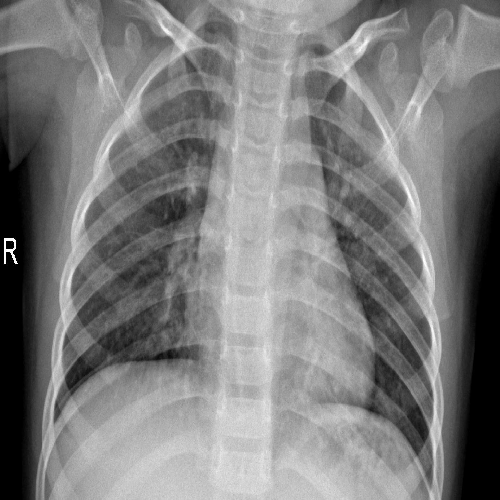

In [195]:
person1

In [196]:
person1 = img_to_array(person1) / 255.0

In [197]:
np.shape(person1)

(500, 500, 1)

In [198]:
person1 = np.expand_dims(person1 , axis=0)
person1

array([[[[0.1882353 ],
         [0.20784314],
         [0.1882353 ],
         ...,
         [0.28235295],
         [0.2901961 ],
         [0.28627452]],

        [[0.1882353 ],
         [0.20784314],
         [0.1882353 ],
         ...,
         [0.3137255 ],
         [0.2901961 ],
         [0.29803923]],

        [[0.1882353 ],
         [0.20784314],
         [0.1882353 ],
         ...,
         [0.30980393],
         [0.3019608 ],
         [0.30588236]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]]], dtype=float32)

In [199]:
np.shape(person1)

(1, 500, 500, 1)

In [200]:
y_pred_person1 = model.predict(person1)
if y_pred_person1 > 0.7 :
    print(f'PNEUMONIA with probability : {y_pred_person1[0][0]}')
else :
    print(f'NORMAL with probability : {y_pred_person1[0][0]}')

1/1 [==============================] - 0s 63ms/step
NORMAL with probability : 0.09525320678949356


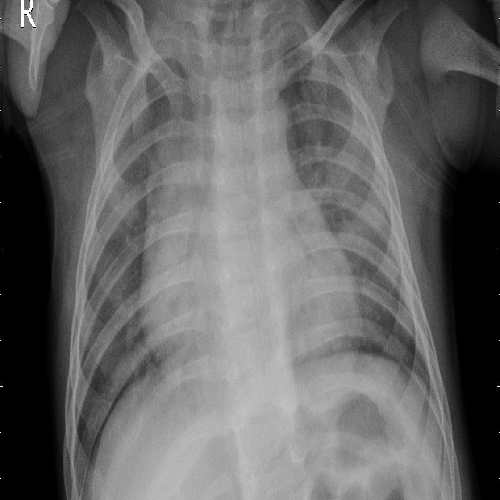

In [201]:
person2 = image.load_img('person1650_virus_2854.jpeg' , target_size=(500,500) , color_mode='grayscale')
person2

In [202]:
person2 = img_to_array(person2) / 255.0
person2 = np.expand_dims(person2 , axis=0)
y_pred_person2 = model.predict(person2)
if y_pred_person2 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person2[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person2[0][0]}')

1/1 [==============================] - 0s 55ms/step
PNEUMONIA with probability : 0.8104093074798584


<font size=5>predict X_ray images</font>

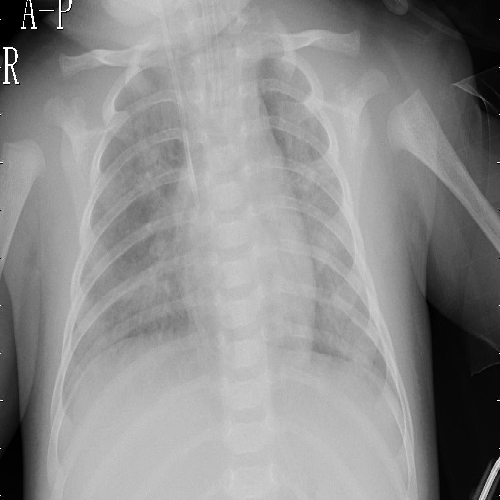

In [203]:
person3 = image.load_img('person1951_bacteria_4882.jpeg' , target_size=(500,500) , color_mode='grayscale')
person3

In [204]:
person3 = img_to_array(person3) / 255.0
person3 = np.expand_dims(person3 , axis=0)
y_pred_person3 = model.predict(person3)
if y_pred_person3 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person3[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person3[0][0]}')

1/1 [==============================] - 0s 54ms/step
PNEUMONIA with probability : 0.8857538104057312


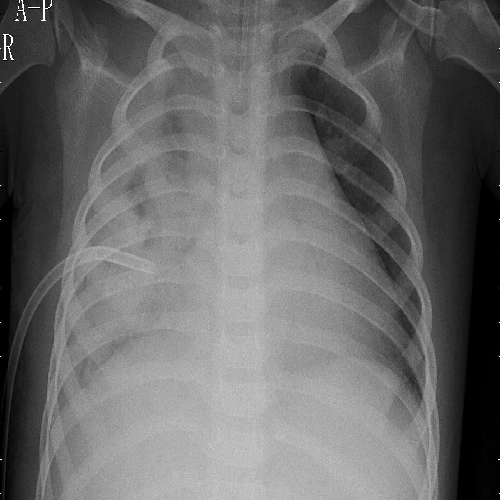

In [205]:
person4 = image.load_img('person1938_bacteria_4854.jpeg' , target_size=(500,500) , color_mode='grayscale')
person4

In [206]:
person4 = img_to_array(person4) / 255.0
person4 = np.expand_dims(person4 , axis=0)
y_pred_person4 = model.predict(person4)
if y_pred_person4 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person4[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person4[0][0]}')

1/1 [==============================] - 0s 46ms/step
NORMAL with probability : 0.661872386932373


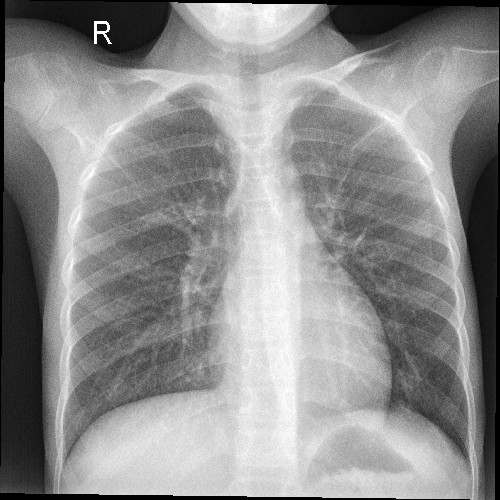

In [207]:
person5 = image.load_img('NORMAL2-IM-0941-0001.jpeg' , target_size=(500,500) , color_mode='grayscale')
person5

In [208]:
person5 = img_to_array(person5) / 255.0
person5 = np.expand_dims(person5 , axis=0)
y_pred_person5 = model.predict(person5)
if y_pred_person5 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person5[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person5[0][0]}')

1/1 [==============================] - 0s 61ms/step
NORMAL with probability : 0.039950836449861526


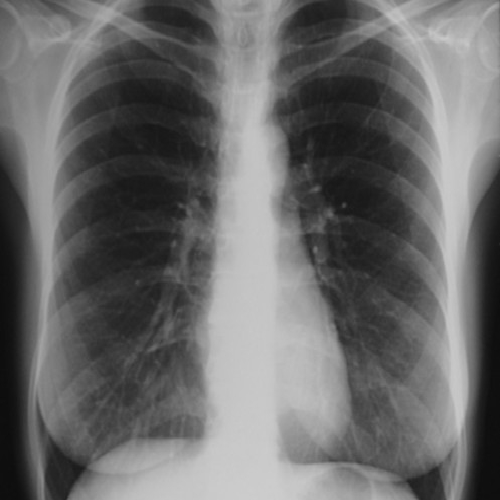

In [209]:
person6 = image.load_img('600600p579EDNmaincache_993844-497x423.jpg' , target_size=(500,500) , color_mode='grayscale')
person6

In [210]:
person6 = img_to_array(person6) / 255.0
person6 = np.expand_dims(person6 , axis=0)
y_pred_person6 = model.predict(person6)
if y_pred_person6 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person6[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person6[0][0]}')

1/1 [==============================] - 0s 60ms/step
NORMAL with probability : 0.6551629900932312


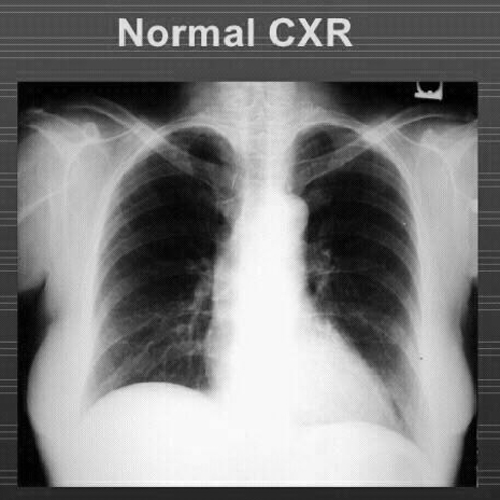

In [211]:
person7 = image.load_img('1.jpg' , target_size=(500,500) , color_mode='grayscale')
person7

In [212]:
person7 = img_to_array(person7) / 255.0
person7 = np.expand_dims(person7 , axis=0)
y_pred_person7 = model.predict(person7)
if y_pred_person7 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person7[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person7[0][0]}')

1/1 [==============================] - 0s 42ms/step
NORMAL with probability : 0.05074778571724892


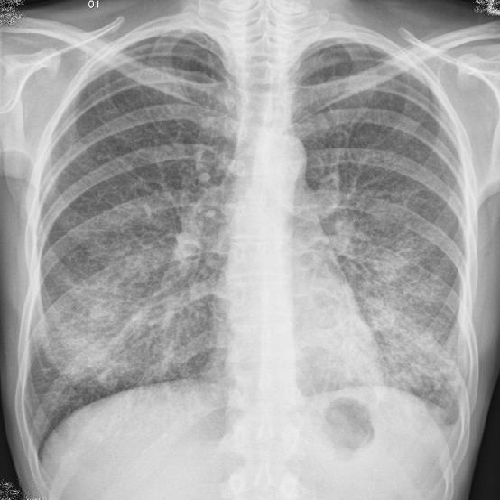

In [216]:
person8 = image.load_img('319c43fb5c1c2fca2a4e710a7a6c4a_big_gallery.jpg' , target_size=(500,500) , color_mode='grayscale')
person8

In [217]:
person8 = img_to_array(person8) / 255.0
person8 = np.expand_dims(person8 , axis=0)
y_pred_person8 = model.predict(person8)
if y_pred_person8 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person8[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person8[0][0]}')

1/1 [==============================] - 0s 47ms/step
NORMAL with probability : 0.03526318073272705


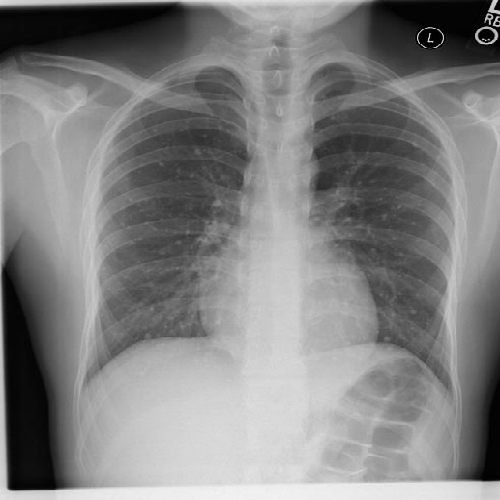

In [218]:
person9 = image.load_img('debc366fbee881069b1bd4b23a8020_big_gallery.jpg' , target_size=(500,500) , color_mode='grayscale')
person9

In [219]:
person9 = img_to_array(person9) / 255.0
person9 = np.expand_dims(person9 , axis=0)
y_pred_person9 = model.predict(person9)
if y_pred_person9 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person9[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person9[0][0]}')

1/1 [==============================] - 0s 49ms/step
PNEUMONIA with probability : 0.7137963771820068


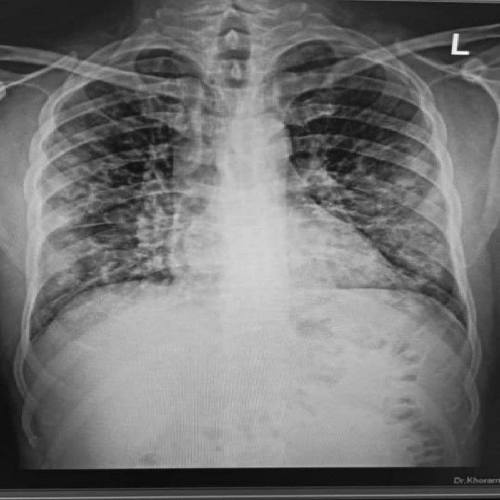

In [220]:
person10 = image.load_img('photo_2025-03-30_00-35-03.jpg' , target_size=(500,500) , color_mode='grayscale')
person10

In [221]:
person10 = img_to_array(person10) / 255.0
person10 = np.expand_dims(person10 , axis=0)
y_pred_person10 = model.predict(person10)
if y_pred_person10 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person10[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person10[0][0]}')



1/1 [==============================] - 0s 52ms/step
PNEUMONIA with probability : 0.937997043132782


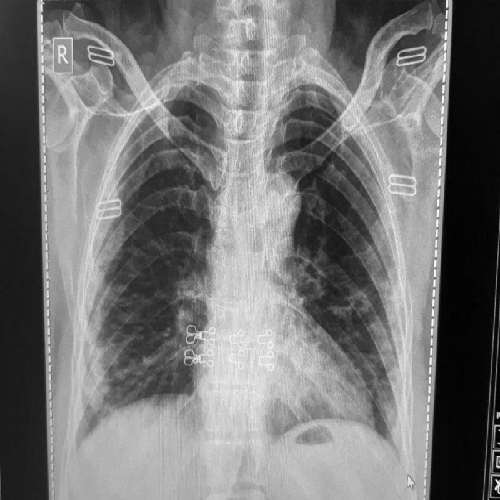

In [222]:
person11 = image.load_img('photo_2025-03-30_00-35-04 (2).jpg' , target_size=(500,500) , color_mode='grayscale')
person11

In [223]:
person11 = img_to_array(person11) / 255.0
person11 = np.expand_dims(person11 , axis=0)
y_pred_person11 = model.predict(person11)
if y_pred_person11 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person11[0][0]}')

else:
    print(f'NORMAL with probability : {y_pred_person11[0][0]}')


1/1 [==============================] - 0s 52ms/step
NORMAL with probability : 0.051795318722724915


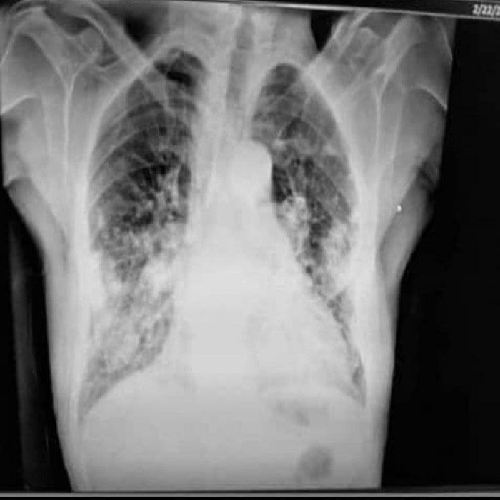

In [225]:
person12 = image.load_img('photo_2025-03-30_00-35-04.jpg' , target_size=(500,500) , color_mode='grayscale')
person12

In [226]:
person12 = img_to_array(person12) / 255.0
person12 = np.expand_dims(person12 , axis=0)
y_pred_person12 = model.predict(person12)
if y_pred_person12 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person12[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person12[0][0]}')

1/1 [==============================] - 0s 49ms/step
PNEUMONIA with probability : 0.9830470681190491
